In [1]:
import pickle as pkl
import json
import numpy as np
from collections import defaultdict
from pycocotools.coco import COCO
from pycocotools.cocoeval import COCOeval
from tqdm import tqdm
from pathlib import Path
import os
import cv2
%matplotlib inline
import matplotlib.pyplot as plt
import opencv_jupyter_ui as jcv2
from collections import defaultdict
import numpy as np
MIN_SCORE = 0.175
MIN_SCORE_DETR  = 0.4

In [2]:
object_classes = [
    "Car",
    "Truck",
    "Other",
    "StopSign",
    "SpeedLimitSign",
]

detr_object_classes = {v: k for k, v in {1: "Car", 2: "Truck", 3: "Other", 4: "StopSign", 5: "SpeedLimitSign"}.items()}
object_classes = {i: detr_object_classes[x] for i, x in enumerate(object_classes)}

# Format and Filter Data

In [3]:
def nms(boxes, scores, iou_thresh=None):

    dets = np.column_stack((boxes, scores))
    iou_thresh = iou_thresh or 0.5
    x1 = dets[:, 0]
    y1 = dets[:, 1]
    x2 = dets[:, 2] + dets[:, 0]
    y2 = dets[:, 3] + dets[:, 1]
    
    scores = dets[:, 4]

    areas = (x2 - x1 + 1) * (y2 - y1 + 1)
    order = scores.argsort()[::-1]

    center_x = (x1 + x2) / 2
    center_y = (y1 + y2) / 2

    keep = []
    while order.size > 0:
        i = order[0]
        keep.append(i)
        xx1 = np.maximum(x1[i], x1[order[1:]])
        yy1 = np.maximum(y1[i], y1[order[1:]])
        xx2 = np.minimum(x2[i], x2[order[1:]])
        yy2 = np.minimum(y2[i], y2[order[1:]])

        w = np.maximum(0.0, xx2 - xx1 + 1)
        h = np.maximum(0.0, yy2 - yy1 + 1)
        intersection = w * h
        iou = intersection / (areas[i] + areas[order[1:]] - intersection)

        smallest_enclosing_box_x1 = np.minimum(x1[i], x1[order[1:]])
        smallest_enclosing_box_x2 = np.maximum(x2[i], x2[order[1:]])
        smallest_enclosing_box_y1 = np.minimum(y1[i], y1[order[1:]])
        smallest_enclosing_box_y2 = np.maximum(y2[i], y2[order[1:]])

        square_of_the_diagonal = (
            smallest_enclosing_box_x2 - smallest_enclosing_box_x1
        ) ** 2 + (smallest_enclosing_box_y2 - smallest_enclosing_box_y1) ** 2

        square_of_center_distance = (center_x[i] - center_x[order[1:]]) ** 2 + (
            center_y[i] - center_y[order[1:]]
        ) ** 2

        # Add 1e-10 for numerical stability.
        diou = iou - square_of_center_distance / (square_of_the_diagonal + 1e-10)
        inds = np.where(diou <= iou_thresh)[0]
        order = order[inds + 1]
    return keep

In [4]:
ann_file = '/data/antonio/converted/instances_test2017.json'
annos = json.load(open(ann_file))
split_file = "/data/antonio/unified_road/v8/test.txt"
custom_img_dir = "/data/antonio/unified_road/images/"
file_names = [
    os.path.join(custom_img_dir, Path(x))
    for x in open(split_file).read().split("\n")
    if x
]
annos_by_image = defaultdict(lambda: defaultdict(list))
for x in annos['annotations']:
    iid = x['id']
    imgid = x['image_id']
    cid = x['category_id']
    bbox = x['bbox']
    area = x['area']
    segmentation = x['segmentation']
    
    annos_by_image[imgid]['bbox'].append(bbox)
    annos_by_image[imgid]['id'].append(iid)
    annos_by_image[imgid]['area'].append(area)
    annos_by_image[imgid]['segmentation'].append(segmentation)
    annos_by_image[imgid]['category_id'].append(cid)

        

In [5]:
yolo = pkl.load(open("./temp_results_2.pkl", "rb"))

In [6]:
yolo_results = []
filtered_yolo_results = []
filename2id = {x['file_name']: x['id'] for x in annos['images']}
for imgid, x in enumerate(tqdm(yolo)):
    file_name = file_names[imgid].split("/")[-1]
    imgid = filename2id[file_name]
    assert len(x['bbox_results']) == 1
    boxes = [y for y in x['bbox_results'][0] if y.size]
    if not boxes:
        continue
    
    boxes = np.concatenate(boxes, axis=0)
    
    confs = boxes[:, 4]
    cids = np.array([int(object_classes[z]) for z in boxes[:, -1].tolist()])
    #cids = np.array([int(z)+1 for z in boxes[:, -1].tolist()])
    boxes = boxes[:, :4]
    boxes[:, 2] = boxes[:, 2] - boxes[:, 0]
    boxes[:, 3] = boxes[:, 3] - boxes[:, 1]
    keep = nms(boxes, confs, iou_thresh=0.5)
    
 
    boxes = boxes[keep]
    confs = confs[keep]
    cids = cids[keep]
    
    
    for box, conf, cid in zip(boxes, confs, cids):
        image = {
            "image_id": imgid,
            "category_id": cid,
            "bbox": list(box),
            "score": conf
        }
        yolo_results.append(image)
    
    
    
    
    score_keep = confs >= MIN_SCORE
    
    
    boxes = boxes[score_keep]
    confs = confs[score_keep]
    cids = cids[score_keep]
    


    for box, conf, cid in zip(boxes, confs, cids):
        image = {
            "image_id": imgid,
            "category_id": cid,
            "bbox": list(box),
            "score": conf
        }
        filtered_yolo_results.append(image)

100%|████████████████████████████████████████████████████| 42552/42552 [00:29<00:00, 1459.68it/s]


In [35]:
filtered_yolo_list = []
for x in tqdm(filtered_yolo_results):
    filtered_yolo_list.append([x['image_id'], x['category_id'], *x['bbox'], x['score']])
    
yolo_list = []
for x in tqdm(yolo_results):
    yolo_list.append([x['image_id'], x['category_id'], *x['bbox'], x['score']])

100%|███████████████████████████████████████████████| 577787/577787 [00:00<00:00, 1474516.95it/s]


In [8]:
detr = json.load(open("./bbox.json"))

In [23]:
filtered_detr = [x for x in detr if x['score'] >= MIN_SCORE_DETR]
detr_by_image = defaultdict(lambda: defaultdict(list))
for x in tqdm(filtered_detr):
    imgid = x['image_id']
    cid = x['category_id']
    bbox = x['bbox']
    score = x['score']
    
    detr_by_image[imgid]['bbox'].append(bbox)
    detr_by_image[imgid]['score'].append(score)
    detr_by_image[imgid]['category_id'].append(cid)
    
filtered_detr_nms = []
for k, x in tqdm(detr_by_image.items()):
    boxes = np.array(x['bbox'])
    scores = np.array(x['score'])
    cids = np.array(x['category_id'])
    
    keep = nms(boxes, scores)
    
    boxes = boxes[keep]
    scores = scores[keep]
    cids = cids[keep]

    
    for box, conf, cid in zip(boxes, scores, cids):
        image = {
            "image_id": k,
            "category_id": cid,
            "bbox": list(box),
            "score": conf
        }
        filtered_detr_nms.append(image)


100%|████████████████████████████████████████████████████| 35805/35805 [00:10<00:00, 3350.55it/s]


In [10]:
filtered_detr_list = []
for x in tqdm(filtered_detr):
    filtered_detr_list.append([x['image_id'], x['category_id'], *x['bbox'], x['score']])
    #break
filtered_detr_nms_list = []
for x in tqdm(filtered_detr_nms):
    filtered_detr_nms_list.append([x['image_id'], x['category_id'], *x['bbox'], x['score']])
    #break
detr_list = []
for x in tqdm(detr):
    detr_list.append([x['image_id'], x['category_id'], *x['bbox'], x['score']])
    #break

100%|████████████████████████████████████████████| 12765600/12765600 [00:16<00:00, 797357.18it/s]


In [36]:
print("detr boxes: ", len(detr))
print("filtered detr boxes: ", len(filtered_detr))
print("filtered detr nms boxes: ", len(filtered_detr_nms))
print("yolo boxes: ", len(yolo_results))
print("filtered yolo boxes: ", len(filtered_yolo_results))
print("gt boxes: ", len(annos['annotations']))

detr boxes:  12765600
filtered detr boxes:  241105
filtered detr nms boxes:  231770
yolo boxes:  577787
filtered yolo boxes:  239736
gt boxes:  240389


# Visualize Images

In [12]:
def plot_boxes(imgid, annos, file_names, detr_results=None, yolo_results=None, cid=None):
    image_path = "/data/antonio/unified_road/images/" + [x['file_name'] for x in annos['images'] if x['id'] == imgid][0]
    
    output_path = "viz/" + image_path.split("/")[-1]
    image = cv2.imread(image_path)
    height, width, _ = image.shape
    new_width = 1280
    new_height = 720
    image = cv2.resize(image, (new_width, new_height))
    sx = new_width / width
    sy = new_height / height

    gt_boxes = [x['bbox'] for x in annos['annotations'] if x['image_id'] == imgid]
    
    
    # Draw bounding boxes on the image
    for box in gt_boxes:
        x, y, w, h = box
        x, y, w, h = int(x * sx), int(y * sy), int(w * sx), int(h * sy)
        cv2.rectangle(image, (x, y), (x + w, y + h), (0, 255, 0), 1)  # Green rectangle
    if detr_results is not None:
        boxes = [x for x in detr_results if x['image_id'] == imgid]
        detr_boxes = []
        for x in boxes:
            if cid is not None:
                if x['category_id'] != cid:
                    continue
#             if x['score'] >= MIN_SCORE_DETR:
            detr_boxes.append(x['bbox'])
        # detr_boxes = np.array([x["bbox"] for x in detr_results if x['image_id'] == imgid])
        for box in detr_boxes:
            x, y, w, h = box
            x, y, w, h = int(x * sx), int(y * sy), int(w * sx), int(h * sy)
            # x, y, w, h = int(x), int(y), int(w), int(h)
            cv2.rectangle(image, (x, y), (x + w, y + h), (0, 0, 255), 1)  # Green rectangle
   
    if yolo_results is not None:
        boxes = [x for x in yolo_results if x['image_id'] == imgid]
        yolo_boxes = []
        for x in boxes:
            if cid is not None:
                if x['category_id'] != cid:
                    continue
#             if x['score'] >= MIN_SCORE:
            yolo_boxes.append(x['bbox'])
        #yolo_boxes = np.array([x["bbox"] for x in yolo_results if x['image_id'] == imgid])
        # raise Exception(yolo_boxes)
        for box in yolo_boxes:
            x, y, w, h = box
            # x, y, w, h = int(x), int(y), int(w), int(h)
            x, y, w, h = int(x * sx), int(y * sy), int(w * sx), int(h * sy)
            cv2.rectangle(image, (x, y), (x + w, y + h), (255, 0, 0), 1)  # Green rectangle
    
    #plt.rcParams['figure.dpi'] = 100
    #plt.imshow(image[..., ::-1])
    #plt.axis('off')
    #plt.show()
    jcv2.imshow("", image)
    #jcv2.waitKey(0)
    jcv2.destroyAllWindows()
    #jcv2.imwrite(output_path, image)

In [24]:
# find image without gt stop sign annotation but where prediction has stop sign annotation
print("false positives:")
j = 0 
fps = 0
total_stop_signs = 0
tps = 0
for i, (k,v)  in enumerate(tqdm(annos_by_image.items())):
    cids = v['category_id']
    detr_item = detr_by_image[k]
    #if k == 30600:
    #    raise Exception(detr_item['category_id'].count(4), cids.count(4))
        
    if detr_item['category_id'].count(4) > cids.count(4):
    #if detr_item['category_id'].count(4) == 0 and cids.count(4)> 0:
        print(k, f"detr #: {detr_item['category_id'].count(4)}", f"gt #: {cids.count(4)}", f"total: {j}")
        fps += detr_item['category_id'].count(4) - cids.count(4)
        tps += cids.count(4)
        j += 1
# find image without gt stop sign annotation but where prediction has stop sign annotation
print("----------------------------------------------------------")
print("false negatives:")
j = 0 
total_missed = 0
for i, (k,v)  in enumerate(tqdm(annos_by_image.items())):
    cids = v['category_id']
    detr_item = detr_by_image[k]
    if detr_item['category_id'].count(4) == 0 and cids.count(4)> 0:
        print(k, f"detr #: {detr_item['category_id'].count(4)}", f"gt #: {cids.count(4)}", f"total: {j}")
        total_missed += cids.count(4) 
        #total_stop_signs += cids.count(4)
    
        j += 1
        
for i, (k,v)  in enumerate((annos_by_image.items())):
    cids = v['category_id']
    detr_item = detr_by_image[k]
    #if detr_item['category_id'].count(4) == cids.count(4):
    total_stop_signs += cids.count(4)
    if not detr_item['category_id'].count(4) > cids.count(4):
        tps += detr_item['category_id'].count(4)
print("----------------------------------------------------------")
print(f"total_stop_signs: {total_stop_signs}")
print(f"tps: {tps}, recall: {tps/total_stop_signs}")
print(f"fps: {fps} precision: {tps/(tps+fps)}, ")
print(f"fns (total missed): {total_missed}, % missed: {total_missed/total_stop_signs}")

false positives:


100%|██████████████████████████████████████████████████| 35901/35901 [00:00<00:00, 235743.81it/s]


4983 detr #: 1 gt #: 0 total: 0
5027 detr #: 2 gt #: 1 total: 1
5109 detr #: 2 gt #: 1 total: 2
5845 detr #: 1 gt #: 0 total: 3
6027 detr #: 1 gt #: 0 total: 4
6257 detr #: 2 gt #: 1 total: 5
6303 detr #: 2 gt #: 1 total: 6
6428 detr #: 1 gt #: 0 total: 7
6850 detr #: 1 gt #: 0 total: 8
6863 detr #: 2 gt #: 1 total: 9
6986 detr #: 1 gt #: 0 total: 10
7024 detr #: 1 gt #: 0 total: 11
7084 detr #: 2 gt #: 1 total: 12
7152 detr #: 1 gt #: 0 total: 13
7234 detr #: 1 gt #: 0 total: 14
7275 detr #: 1 gt #: 0 total: 15
7473 detr #: 1 gt #: 0 total: 16
8028 detr #: 1 gt #: 0 total: 17
8567 detr #: 2 gt #: 1 total: 18
8613 detr #: 1 gt #: 0 total: 19
9276 detr #: 1 gt #: 0 total: 20
9634 detr #: 1 gt #: 0 total: 21
9669 detr #: 1 gt #: 0 total: 22
9733 detr #: 1 gt #: 0 total: 23
9846 detr #: 1 gt #: 0 total: 24
10145 detr #: 1 gt #: 0 total: 25
10725 detr #: 1 gt #: 0 total: 26
11475 detr #: 1 gt #: 0 total: 27
11516 detr #: 1 gt #: 0 total: 28
11635 detr #: 1 gt #: 0 total: 29
11714 detr #: 1

  0%|                                                                  | 0/35901 [00:00<?, ?it/s]

5342 detr #: 0 gt #: 1 total: 0
5693 detr #: 0 gt #: 1 total: 1
5768 detr #: 0 gt #: 1 total: 2
6659 detr #: 0 gt #: 1 total: 3
6921 detr #: 0 gt #: 1 total: 4
7012 detr #: 0 gt #: 2 total: 5
8058 detr #: 0 gt #: 1 total: 6
8553 detr #: 0 gt #: 1 total: 7
10579 detr #: 0 gt #: 1 total: 8
12052 detr #: 0 gt #: 1 total: 9
12175 detr #: 0 gt #: 1 total: 10
13169 detr #: 0 gt #: 1 total: 11
13446 detr #: 0 gt #: 1 total: 12
13705 detr #: 0 gt #: 2 total: 13
14084 detr #: 0 gt #: 1 total: 14
14122 detr #: 0 gt #: 1 total: 15
14318 detr #: 0 gt #: 1 total: 16
14598 detr #: 0 gt #: 1 total: 17
14819 detr #: 0 gt #: 1 total: 18
14825 detr #: 0 gt #: 1 total: 19
14909 detr #: 0 gt #: 1 total: 20
16250 detr #: 0 gt #: 1 total: 21
16504 detr #: 0 gt #: 1 total: 22
16550 detr #: 0 gt #: 1 total: 23
17037 detr #: 0 gt #: 1 total: 24
17228 detr #: 0 gt #: 2 total: 25
17738 detr #: 0 gt #: 1 total: 26
18505 detr #: 0 gt #: 1 total: 27
19211 detr #: 0 gt #: 1 total: 28
20334 detr #: 0 gt #: 1 total: 2

100%|██████████████████████████████████████████████████| 35901/35901 [00:00<00:00, 549388.54it/s]


----------------------------------------------------------
total_stop_signs: 2951
tps: 2813, recall: 0.9532361911216537
fps: 2030 precision: 0.5808383233532934, 
fns (total missed): 90, % missed: 0.030498136225008472


In [28]:
plot_boxes(15765, annos, file_names, detr_results=filtered_detr, cid=4)

In [15]:
# find image with only small objects
j = 0 
for i, (k,v)  in enumerate(tqdm(annos_by_image.items())):
    areas = v['area']
    if all ([x < 32**2 for x in areas]) and len(areas) >= 10:
        print(k)
        j += 1
    if j == 20:
        break

 43%|█████████████████████▎                            | 11965/28044 [00:00<00:00, 515361.25it/s]

5544
7032
7476
7734
8443
9625
9672
11123
12267
13218
13791
14143
15329
15478
15672
15822
18334
19369
19966
20991


In [16]:
iid = 9672
plot_boxes(iid, annos, file_names, detr_results=filtered_detr, cid=None)
plot_boxes(iid, annos, file_names, yolo_results=filtered_yolo_results, cid=None)

# mAP calculations

In [16]:
from copy import deepcopy

def calculate_iou(box1, box2):
    """
    Calculate the intersection over union (IoU) between two bounding boxes.
    Parameters:
        box1 (list): [x, y, width, height] of the first box
        box2 (list): [x, y, width, height] of the second box
    Returns:
        float: Intersection over Union (IoU) value
    """
    x1, y1, w1, h1 = box1
    x2, y2, w2, h2 = box2

    # Calculate coordinates of intersection rectangle
    x_intersection = max(x1, x2)
    y_intersection = max(y1, y2)
    w_intersection = max(0, min(x1 + w1, x2 + w2) - x_intersection)
    h_intersection = max(0, min(y1 + h1, y2 + h2) - y_intersection)

    # Calculate areas of intersection and union rectangles
    intersection_area = w_intersection * h_intersection
    box1_area = w1 * h1
    box2_area = w2 * h2
    union_area = box1_area + box2_area - intersection_area

    # Calculate IoU
    iou = intersection_area / union_area

    return iou

def calculate_ap(recall, precision):
    """
    Calculate Average Precision (AP) given the recall and precision arrays.
    Parameters:
        recall (ndarray): Array of recall values
        precision (ndarray): Array of precision values
    Returns:
        float: Average Precision (AP) value
    """
    
    # Calculate the area under the precision-recall curve
    ap = np.sum((recall[1:] - recall[:-1]) * precision[1:])

    return ap

def calculate_map(ground_truth, predictions, iou_threshold=0.5, sml=False):
    """
    Calculate the mean Average Precision (mAP) given ground truth and predicted bounding boxes.
    Parameters:
        ground_truth (list): List of ground truth bounding boxes in the format [image_id, category_id, x, y, width, height]
        predictions (list): List of predicted bounding boxes in the format [image_id, category_id, x, y, width, height, confidence]
        iou_threshold (float): Intersection over Union (IoU) threshold for matching predictions to ground truth
    Returns:
        float: Mean Average Precision (mAP) value
    """
    
    if sml:
        predictions = deepcopy(predictions)
        ground_truth = deepcopy(ground_truth)
        # We need to change classes into small medium and large only
        print("converting classes to small|medium|large")
        for k, v in ground_truth.items():
            new_cids = []
            for cid, area in zip(v['category_id'], v['area']):
                if area < 32**2:
                    new_cids.append(0)
                elif area < 96**2:
                    new_cids.append(1)
                else:
                    new_cids.append(2)
            v['category_id'] = new_cids
            ground_truth[k] = v

        for i, box in enumerate(predictions):
            x, y, w, h = box[2:6]
            area = w * h
            if area < 32**2:
                cid = 0
            elif area < 96**2:
                cid = 1
            else:
                cid = 2
            predictions[i][1] = cid
    
    
    
    # Sort predictions by confidence (descending order)
    predictions.sort(key=lambda x: x[6], reverse=True)
    
    classes = set()
    class_nums = defaultdict(int)
    for k,v in ground_truth.items():
        classes |= set(v['category_id'])
        for x in v['category_id']:
            class_nums[x] += 1
            
    adj = min(class_nums)
    #raise Exception(classes)
    #adj = 0
    num_classes = len(classes)
    
    true_positives = [[] for _ in range(num_classes)]
    false_positives = [[] for _ in range(num_classes)]
    num_gt_boxes = [0] * num_classes
    
    #num_gt_boxes = []
    for k,v in class_nums.items():
        num_gt_boxes[k-adj] = v
    #raise Exception(num_gt_boxes)
    
    
    seen_ids = set()
    for prediction in tqdm(predictions):
        image_id, category_id, _, _, _, _, confidence = prediction
        gt_boxes = [[image_id, x[1], *x[0]] for x in zip(ground_truth[image_id]['bbox'], ground_truth[image_id]['category_id']) if x[1] == category_id]
        gt_ids = [x[0] for x in zip(ground_truth[image_id]['id'], ground_truth[image_id]['category_id']) if x[1] == category_id]
        if len(gt_boxes) == 0:
            false_positives[category_id-adj].append(1)
            true_positives[category_id-adj].append(0)
            continue

        gt_boxes = np.array(gt_boxes)[:, 2:]
        pred_box = prediction[2:6]
        ious = np.array([calculate_iou(pred_box, gt_box) for gt_box in gt_boxes])
        max_iou_idx = np.argmax(ious)

        if ious[max_iou_idx] >= iou_threshold:
            iid = gt_ids[max_iou_idx]
            if iid not in seen_ids:
                false_positives[category_id-adj].append(0)
                true_positives[category_id-adj].append(1)
                seen_ids.add(iid)
            else:
                false_positives[category_id-adj].append(1)
                true_positives[category_id-adj].append(0)
        else:
            false_positives[category_id-adj].append(1)
            true_positives[category_id-adj].append(0)

    # Calculate precision and recall for each class
    precision = []
    recall = []
    for i in range(num_classes):
        tp = np.array(true_positives[i])
        fp = np.array(false_positives[i])
        tp_cumsum = np.cumsum(tp)
        fp_cumsum = np.cumsum(fp)

        # Calculate recall and precision values
        recall_values = tp_cumsum / (num_gt_boxes[i] + np.spacing(1))
        precision_values = tp_cumsum / (tp_cumsum + fp_cumsum)

        # Append sentinel values to ensure the curve starts at 0 and ends at last recall value
        recall_values = np.concatenate(([0.0], recall_values, [recall_values[-1]]))
        precision_values = np.concatenate(([1.0], precision_values, [0.0]))

        # Interpolate precision to obtain a more smooth curve
        for j in range(precision_values.size - 1, 0, -1):
            precision_values[j - 1] = np.maximum(precision_values[j - 1], precision_values[j])

        recall.append(recall_values)
        precision.append(precision_values)

    # Calculate AP for each class
    ap = [calculate_ap(recall[i], precision[i]) for i in range(num_classes)]

    # Calculate mean AP
    mean_ap = np.mean(ap)

    return mean_ap, ap, recall, precision, true_positives, false_positives

In [ ]:
d_mAP, d_aps, d_recall, d_precision, d_tp, d_fp = calculate_map(annos_by_image, detr_list)
print("mAP: {:.4f}".format(d_mAP), d_aps)

In [ ]:
ds_mAP, ds_aps, ds_recall, ds_precision, ds_tp, ds_fp = calculate_map(annos_by_image, detr_list, sml=True)
print("mAP: {:.4f}".format(ds_mAP), ds_aps)

In [17]:
df_mAP, df_aps, df_recall, df_precision, df_tp, df_fp = calculate_map(annos_by_image, filtered_detr_list)
print("mAP: {:.4f}".format(df_mAP), df_aps)

100%|██████████████████████████████████████████████████| 241105/241105 [00:28<00:00, 8468.16it/s]


mAP: 0.6856 [0.6726719499282836, 0.6585219486504319, 0.5371677531093112, 0.6547169167289936, 0.9049872064495055]


In [33]:
dfs_mAP, dfs_aps, dfs_recall, dfs_precision, dfs_tp, dfs_fp = calculate_map(annos_by_image, filtered_detr_list, sml=True)
print("mAP: {:.4f}".format(dfs_mAP), dfs_aps)

converting classes to small|medium|large


100%|██████████████████████████████████████████████████| 241105/241105 [00:24<00:00, 9839.02it/s]


mAP: 0.7557 [0.5518244638887109, 0.8097531229535667, 0.9054093592845007]


In [37]:
yf_mAP, yf_aps, yf_recall, yf_precision, yf_tp, yf_fp = calculate_map(annos_by_image, filtered_yolo_list)
print("mAP: {:.4f}".format(yf_mAP), yf_aps)

100%|█████████████████████████████████████████████████| 239736/239736 [00:08<00:00, 27069.16it/s]


mAP: 0.0551 [0.2096645272435287, 0.008555324755955364, 0.025526431410454187, 0.0, 0.03153024905540353]


In [38]:
yfs_mAP, yfs_aps, yfs_recall, yfs_precision, yfs_tp, yfs_fp = calculate_map(annos_by_image, filtered_yolo_list, sml=True)
print("mAP: {:.4f}".format(yfs_mAP), yfs_aps)

converting classes to small|medium|large


100%|█████████████████████████████████████████████████| 239736/239736 [00:11<00:00, 21489.86it/s]


mAP: 0.7485 [0.5366565294198293, 0.8089672529875159, 0.8998647262978601]


In [ ]:
y_mAP, y_aps, y_recall, y_precision, y_tp, y_fp = calculate_map(annos_by_image, yolo_list)
print("mAP: {:.4f}".format(y_mAP), y_aps)

In [ ]:
ys_mAP, ys_aps, ys_recall, ys_precision, ys_tp, ys_fp = calculate_map(annos_by_image, yolo_list, sml=True)
print("mAP: {:.4f}".format(ys_mAP), ys_aps)

# PR Curves

In [30]:
def plot_pr_curve(tps, fps, cls, tps2=None, fps2=None, ground_truth=annos_by_image, intrp=True):
    i = cls
    
    class_nums = defaultdict(int)
    for k,v in ground_truth.items():
        for x in v['category_id']:
            class_nums[x] += 1
            
    num_classes = len(class_nums)
    num_gt_boxes = [0] * num_classes
    for k,v in class_nums.items():
        num_gt_boxes[k-1] = v
        #print(k, v)
        
        
    def tpfp_to_pr(tp, fp, intrp=intrp):
        tp_cumsum = np.cumsum(np.array(tp))
        fp_cumsum = np.cumsum(np.array(fp))
        recall_values = tp_cumsum / (num_gt_boxes[i] + np.spacing(1))
        precision_values = tp_cumsum / (tp_cumsum + fp_cumsum)
        
        recall_values = np.concatenate(([0.0], recall_values, [recall_values[-1]]))
        precision_values = np.concatenate(([0.0], precision_values, [0.0]))
        
        if intrp:
            # Interpolate precision to obtain a more smooth curve
            for j in range(precision_values.size - 1, 0, -1):
                precision_values[j - 1] = np.maximum(precision_values[j - 1], precision_values[j])

        return precision_values, recall_values
    
    precision, recall = tpfp_to_pr(tps[i], fps[i])
    plt.plot(recall, precision)
    if tps2 is not None and fps2 is not None:
        precision2, recall2 = tpfp_to_pr(tps2[i], fps2[i])
        plt.plot(recall2, precision2)
    plt.show()

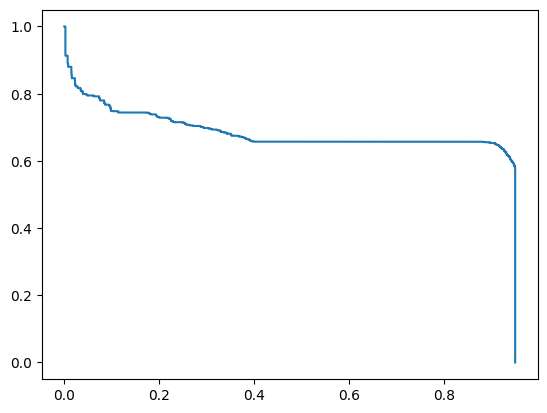

In [46]:
# unfiltered small objects
plot_pr_curve(ds_tp, ds_fp, cls=0, tps2=ys_tp, fps2=ys_fp, intrp=True)

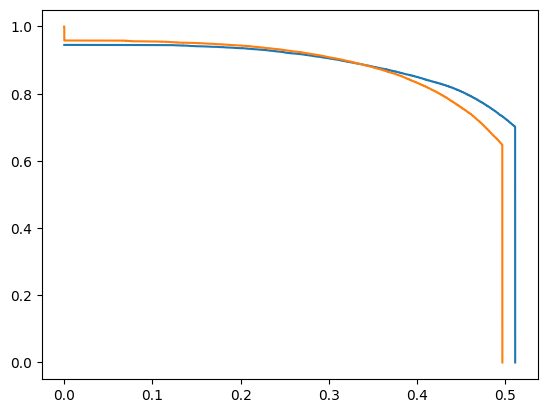

In [39]:
# filtered small objects
plot_pr_curve(dfs_tp, dfs_fp, cls=0, tps2=yfs_tp, fps2=yfs_fp, intrp=True)

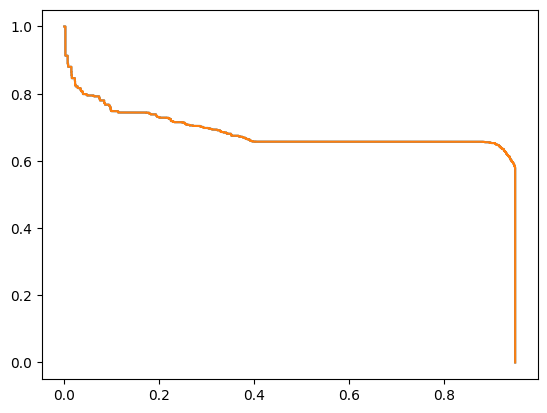

In [32]:
# stop signs DETR
plot_pr_curve(df_tp, df_fp, cls=3, intrp=True, tps2=df_tp, fps2=df_fp)

# COCO Eval Results

In [ ]:
def coco_eval(preds, ann_file):
    # now we do coco eval
    cocoGt = COCO(ann_file)
    cocoDt = cocoGt.loadRes(preds)

    # Initialize the COCO evaluation object
    cocoEval = COCOeval(cocoGt, cocoDt, 'bbox')

    # Run the evaluation
    cocoEval.evaluate()
    cocoEval.accumulate()
    cocoEval.summarize()

    # Get AP and AR values
    print(cocoEval.stats)

## Coco Eval Results for DETR

In [122]:
coco_eval(detr, ann_file)

loading annotations into memory...
Done (t=1.20s)
creating index...
index created!
Loading and preparing results...
DONE (t=40.66s)
creating index...
index created!
Running per image evaluation...
Evaluate annotation type *bbox*
DONE (t=391.25s).
Accumulating evaluation results...
DONE (t=148.44s).
 Average Precision  (AP) @[ IoU=0.50:0.95 | area=   all | maxDets=100 ] = 0.536
 Average Precision  (AP) @[ IoU=0.50      | area=   all | maxDets=100 ] = 0.746
 Average Precision  (AP) @[ IoU=0.75      | area=   all | maxDets=100 ] = 0.577
 Average Precision  (AP) @[ IoU=0.50:0.95 | area= small | maxDets=100 ] = 0.317
 Average Precision  (AP) @[ IoU=0.50:0.95 | area=medium | maxDets=100 ] = 0.615
 Average Precision  (AP) @[ IoU=0.50:0.95 | area= large | maxDets=100 ] = 0.784
 Average Recall     (AR) @[ IoU=0.50:0.95 | area=   all | maxDets=  1 ] = 0.425
 Average Recall     (AR) @[ IoU=0.50:0.95 | area=   all | maxDets= 10 ] = 0.667
 Average Recall     (AR) @[ IoU=0.50:0.95 | area=   all | ma

In [139]:
coco_eval(filtered_detr, ann_file)

loading annotations into memory...
Done (t=1.54s)
creating index...
index created!
Loading and preparing results...
DONE (t=0.35s)
creating index...
index created!
Running per image evaluation...
Evaluate annotation type *bbox*
DONE (t=60.24s).
Accumulating evaluation results...
DONE (t=8.78s).
 Average Precision  (AP) @[ IoU=0.50:0.95 | area=   all | maxDets=100 ] = 0.506
 Average Precision  (AP) @[ IoU=0.50      | area=   all | maxDets=100 ] = 0.684
 Average Precision  (AP) @[ IoU=0.75      | area=   all | maxDets=100 ] = 0.551
 Average Precision  (AP) @[ IoU=0.50:0.95 | area= small | maxDets=100 ] = 0.285
 Average Precision  (AP) @[ IoU=0.50:0.95 | area=medium | maxDets=100 ] = 0.588
 Average Precision  (AP) @[ IoU=0.50:0.95 | area= large | maxDets=100 ] = 0.764
 Average Recall     (AR) @[ IoU=0.50:0.95 | area=   all | maxDets=  1 ] = 0.416
 Average Recall     (AR) @[ IoU=0.50:0.95 | area=   all | maxDets= 10 ] = 0.602
 Average Recall     (AR) @[ IoU=0.50:0.95 | area=   all | maxDet